# Comparación de métodos utilizados

## Aplicando $H_{eff}$ al método de saltos cuánticos

Importamos las librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import ipympl
%matplotlib widget
from qutip import *
from scipy.linalg import expm

Definimos los parámetros a utilizar en el código

In [2]:
# definicion de parámetros
Omega = 1  # frecuencia de Rabi
gamma = 0.03  # tasa de decaimiento
hbar = 1 # se coloca este valor para que en la gráfica se puedan apreciar ambos métodos de resolución
Delta_q = 0.1
times = np.linspace(0, 100, 1000)
dt = times[1] - times[0]

Definimos los operadores de Pauli usando Qobj (Biblioteca de Qutip)

In [3]:
sigma_z = Qobj([[1, 0], [0, -1]])
sigma_plus = Qobj([[0, 0], [1, 0]])
sigma_minus = Qobj([[0, 1], [0, 0]])

Estado inicial del qubit

In [4]:
psi0 = basis(2, 0)  # estado |0>

Definimos el Hamiltoniano del sistema

In [5]:
H = (hbar * Delta_q / 2) * sigma_z + (hbar * Omega / 2) * (sigma_plus + sigma_minus)

Operadores de Lindblad que vamos a utilizar ($L_k$)

In [6]:
L1 = sigma_z
L2 = sigma_minus

Definimos $\rho$ (matriz densidad) para resolver la Ec. Lindblad

In [7]:
rho_initial = ket2dm(psi0)

Ecuación de Lindblad: 
    
\begin{equation}
    \frac{d\rho}{dt} = -\frac{i}{\hbar} [H, \rho] + \sum_{k} \left( L_k \rho L_k^\dagger - \frac{1}{2} \left\{ L_k^\dagger L_k, \rho \right\} \right)
\end{equation}

donde:

- $\rho$ es la matriz densidad del sistema.
- $H$ es el Hamiltoniano del sistema.
- $L_k$ son los operadores de Lindblad que describen los canales de decoherencia y disipación.
- $[H, \rho]$ es el conmutador de $H$ y $\rho$.
- $\{L_k^\dagger L_k, \rho\}$ es el anticonmutador de $L_k^\dagger L_k$ y $\rho$.


Resolución de la Ec. de Lindblad usando Qutip

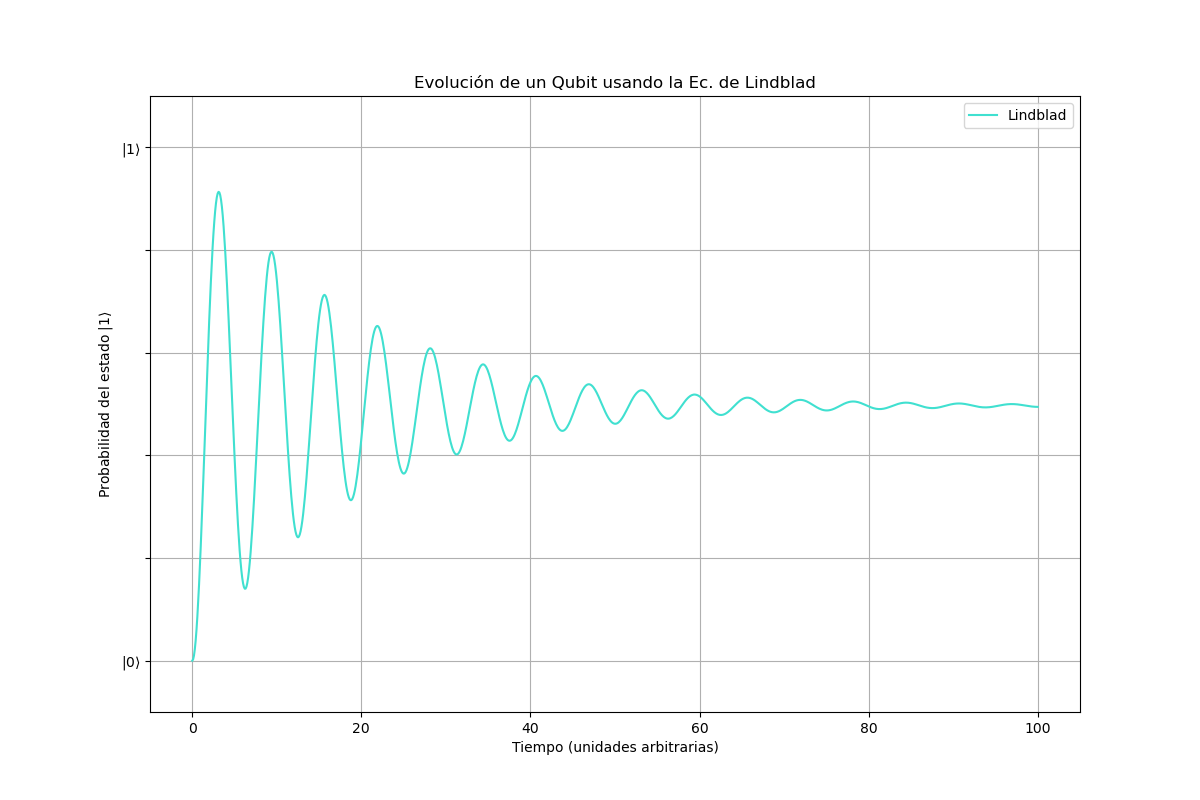

In [14]:
c_ops = [np.sqrt(gamma) * L1, np.sqrt(gamma) * L2]
result_lindblad = mesolve(H, psi0, times, c_ops, [basis(2, 1).proj()])

# Probabilidad del estado |1> en función del tiempo para Lindblad
p1_lindblad = result_lindblad.expect[0]




# Resultado de la ecuación de Lindblad
plt.figure(figsize=(12, 8))
plt.plot(times, p1_lindblad, label='Lindblad', color='turquoise')

plt.xlabel('Tiempo (unidades arbitrarias)')
plt.ylabel('Probabilidad del estado $|1\\rangle$')
plt.yticks(np.linspace(0, 1, 6), [r'$|0\rangle$', '', '', '', '', r'$|1\rangle$'])
plt.xticks(np.linspace(0, 100, 6), ['0', '20', '40', '60', '80', '100'])

plt.ylim(-0.1, 1.1)

plt.title('Evolución de un Qubit usando la Ec. de Lindblad')
plt.legend()
plt.grid()
plt.show()

Definimos el hamiltoniano efectivo $H_{eff}$

In [9]:
H_eff = H - (1j * hbar / 2) * sum([L.dag() * L for L in c_ops])

Usamos el método de saltos cuánticos (MCWF)

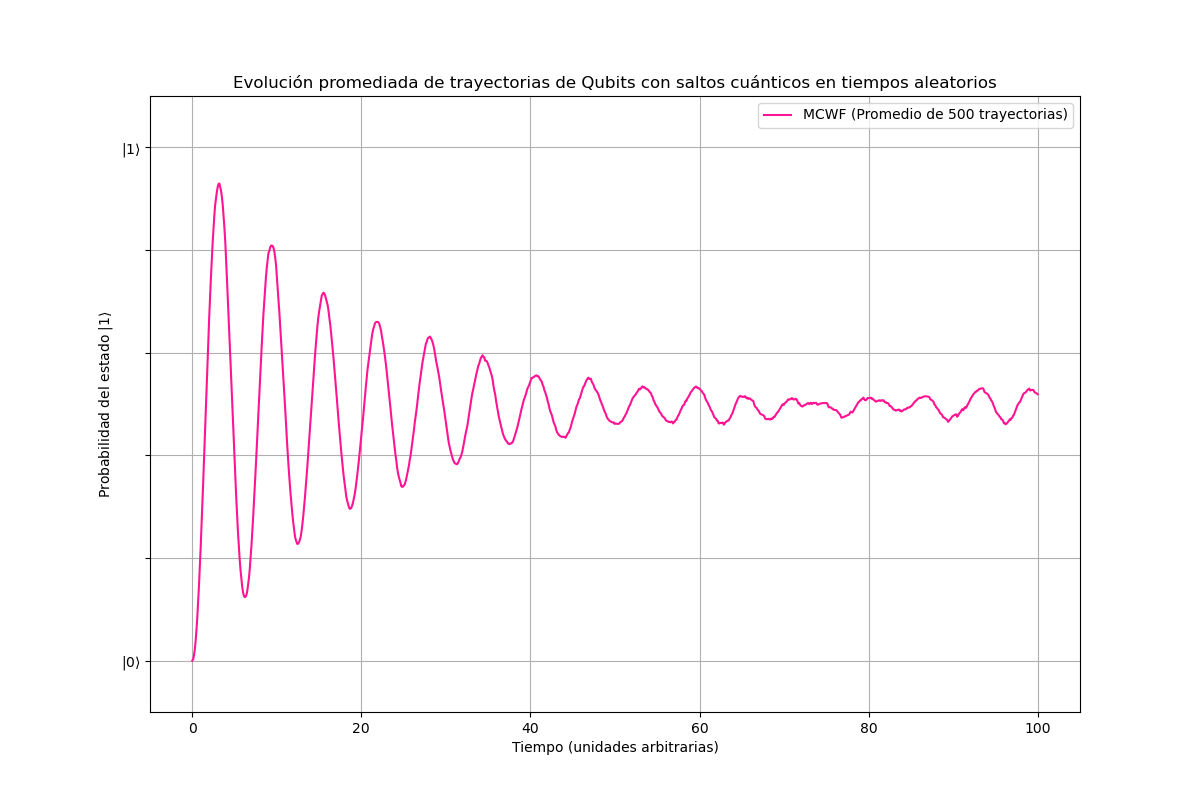

In [10]:
def quantum_jump_evolution(H_eff, L_ops, psi0, times):
    dt = times[1] - times[0]
    state = psi0.copy()
    states_over_time = [state.copy()]
    
    for _ in times[:-1]:
        # Aplicamos la matriz de evolución efectiva
        U_eff = (-1j * H_eff * dt).expm()
        state = (U_eff * state).unit()
        
        # Decaimiento
        jump_probs = [expect(L.dag() * L, state).real * dt for L in L_ops]
        total_jump_prob = sum(jump_probs)
        if np.random.random() < total_jump_prob:
            jump_cumulative = np.cumsum(jump_probs) / total_jump_prob
            rand = np.random.random()
            for i, jump_prob in enumerate(jump_cumulative):
                if rand < jump_prob:
                    state = (L_ops[i] * state).unit()
                    break
        
        states_over_time.append(state.copy())
        
    return states_over_time


# Múltiples realizaciones
num_realizations = 500
all_trajectories = []

for _ in range(num_realizations):
    states_over_time = quantum_jump_evolution(H_eff, c_ops, psi0, times)
    prob_1 = [abs(state.overlap(basis(2, 1)))**2 for state in states_over_time]
    all_trajectories.append(prob_1)

# Promedio de las trayectorias
mean_prob_1 = np.mean(all_trajectories, axis=0)

# Gráficas
plt.figure(figsize=(12, 8))

plt.plot(times, mean_prob_1, label='MCWF (Promedio de 500 trayectorias)', color='deeppink')

plt.xlabel('Tiempo (unidades arbitrarias)')
plt.ylabel('Probabilidad del estado $|1\\rangle$')
plt.yticks(np.linspace(0, 1, 6), [r'$|0\rangle$', '', '', '', '', r'$|1\rangle$'])
plt.xticks(np.linspace(0, 100, 6), ['0', '20', '40', '60', '80', '100'])

plt.ylim(-0.1, 1.1)

plt.title('Evolución promediada de trayectorias de Qubits con saltos cuánticos en tiempos aleatorios')
plt.legend()
plt.grid()
plt.show()

Superponemos ambas gráficas para observar los resultados

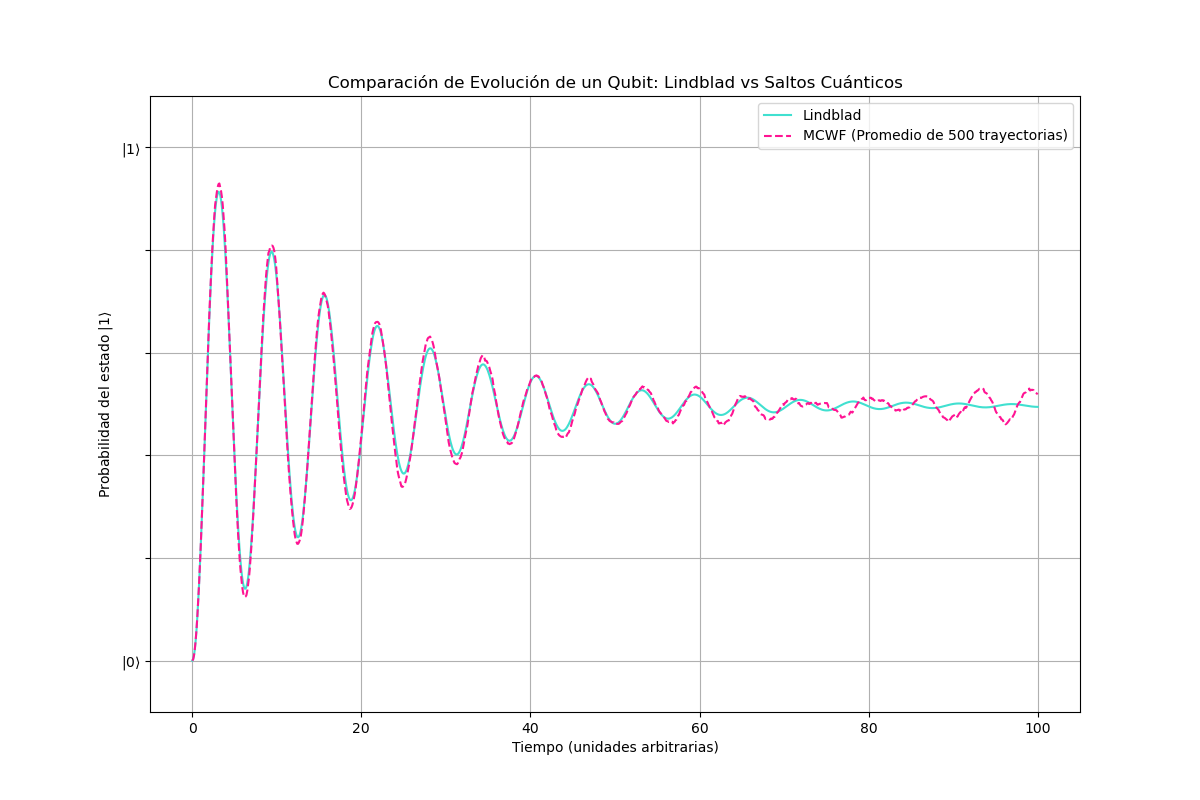

In [12]:
# gráfica
plt.figure(figsize=(12, 8))

# resultado de la ecuación de Lindblad
plt.plot(times, p1_lindblad, label='Lindblad', color='turquoise')

# resultado promedio del método de saltos cuánticos
plt.plot(times, mean_prob_1, label='MCWF (Promedio de 500 trayectorias)', color='deeppink', linestyle='--')

plt.xlabel('Tiempo (unidades arbitrarias)')
plt.ylabel('Probabilidad del estado $|1\\rangle$')
plt.yticks(np.linspace(0, 1, 6), [r'$|0\rangle$', '', '', '', '', r'$|1\rangle$'])
plt.xticks(np.linspace(0, 100, 6), ['0', '20', '40', '60', '80', '100'])

plt.ylim(-0.1, 1.1)

plt.title('Comparación de Evolución de un Qubit: Lindblad vs Saltos Cuánticos')
plt.legend()
plt.grid()
plt.show()